# مدل سازی ماشین لرنینگ بدون اضافه کردن ویژگی های جدید

## وارد کردن کتابخانه‌ها

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno
import h2o
from h2o.estimators import H2ORandomForestEstimator
import warnings
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
warnings.filterwarnings('ignore')

## خواندن داده‌ها

### خواندن داده های 1950 تا 2021

In [2]:
df_estimates = pd.read_excel('../data/WPP2022.xlsx', sheet_name='Estimates', skiprows=16, na_values='...')
# انتخاب تایپ از نوع کشور
df_estimates = df_estimates[df_estimates['Type'] == 'Country/Area'].copy()

# انتخاب ستون های با کوریلیشن کمتر از 0.9
column_list = ["Region, subregion, country or area *",
"Year",
"Births (thousands)",
"Population Density, as of 1 July (persons per square km)",
"Population Sex Ratio, as of 1 July (males per 100 females)",
"Population Growth Rate (percentage)",
"Population Annual Doubling Time (years)",
"Rate of Natural Change (per 1,000 population)",
"Crude Birth Rate (births per 1,000 population)",
"Mean Age Childbearing (years)",
"Sex Ratio at Birth (males per 100 female births)",
"Crude Death Rate (deaths per 1,000 population)",
"Under-Five Deaths, under age 5 (thousands)",
"Net Number of Migrants (thousands)",
"Net Migration Rate (per 1,000 population)",
"Life Expectancy at Birth, both sexes (years)"]

df_estimates = df_estimates[column_list].copy()

# حدف مقادیر تکراری
df_estimates.drop_duplicates(subset=['Region, subregion, country or area *', "Year"], keep='first', inplace=True)
df_estimates.reset_index(drop=True, inplace=True)

In [3]:
df_estimates

,"Region, subregion, country or area *",Year,Births (thousands),"Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",Population Growth Rate (percentage),Population Annual Doubling Time (years),"Rate of Natural Change (per 1,000 population)","Crude Birth Rate (births per 1,000 population)",Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),"Crude Death Rate (deaths per 1,000 population)","Under-Five Deaths, under age 5 (thousands)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)","Life Expectancy at Birth, both sexes (years)"
0,Burundi,1950.0,116.224,86.864,91.947,2.200,31.507,27.788,51.334,30.995,102.5,23.546,29.001,-13.343,-5.893,40.579
1,Burundi,1951.0,117.067,88.757,92.145,2.114,32.788,26.799,50.678,30.996,102.5,23.879,30.669,-13.217,-5.721,40.812
2,Burundi,1952.0,117.770,90.618,92.319,2.036,34.045,26.118,49.933,31.026,102.5,23.815,31.272,-13.715,-5.815,41.003
3,Burundi,1953.0,119.013,92.451,92.488,1.969,35.203,25.844,49.448,31.030,102.5,23.604,31.644,-14.962,-6.216,41.282
4,Burundi,1954.0,119.972,94.287,92.650,1.965,35.275,25.536,48.883,31.036,102.5,23.347,31.915,-14.599,-5.948,41.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17059,Wallis and Futuna Islands,2017.0,0.153,85.257,93.562,-1.106,NaN,5.985,12.713,30.007,104.8,6.728,0.002,-0.201,-16.706,77.531
17060,Wallis and Futuna Islands,2018.0,0.147,84.396,93.301,-0.923,NaN,5.611,12.381,30.012,104.8,6.770,0.002,-0.171,-14.368,77.861
17061,Wallis and Futuna Islands,2019.0,0.144,83.671,93.109,-0.802,NaN,6.112,12.189,30.025,104.8,6.077,0.002,-0.171,-14.489,79.617
17062,Wallis and Futuna Islands,2020.0,0.140,83.246,92.955,-0.215,NaN,5.154,11.997,30.021,104.8,6.843,0.002,-0.083,-7.096,78.764


### خواندن داده های 2022

In [4]:
df_medium = pd.read_excel('../data/WPP2022.xlsx', sheet_name='Medium variant', skiprows=16, na_values='...')

# انتخاب تایپ از نوع کشور
df_medium = df_medium[df_medium['Type'] == 'Country/Area'].copy()

# انتخاب ستون های با کوریلیشن کمتر از 0.9
df_medium = df_medium[column_list].copy()

# انتخاب سال 2022
df_medium = df_medium[df_medium['Year'] == 2022].copy()
df_medium.reset_index(drop=True, inplace=True)

# حدف مقادیر تکراری
df_medium.drop_duplicates(subset=['Region, subregion, country or area *', "Year"], keep='first', inplace=True)
df_medium.reset_index(drop=True, inplace=True)

In [5]:
df_medium

,"Region, subregion, country or area *",Year,Births (thousands),"Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",Population Growth Rate (percentage),Population Annual Doubling Time (years),"Rate of Natural Change (per 1,000 population)","Crude Birth Rate (births per 1,000 population)",Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),"Crude Death Rate (deaths per 1,000 population)","Under-Five Deaths, under age 5 (thousands)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)","Life Expectancy at Birth, both sexes (years)"
0,Burundi,2022.0,439.648,496.708,98.648,2.695,25.720,26.798,34.109,30.652,102.5,7.311,22.214,2.000,0.155,61.977
1,Comoros,2022.0,24.201,449.636,100.946,1.799,38.530,20.359,28.887,30.571,103.2,8.528,1.414,-2.000,-2.387,63.680
2,Djibouti,2022.0,24.549,48.354,98.526,1.374,50.447,12.949,21.911,31.267,103.7,8.962,1.259,0.900,0.803,62.859
3,Eritrea,2022.0,104.981,30.410,97.413,1.710,40.535,21.699,28.426,29.434,103.2,6.727,3.902,-17.152,-4.644,66.604
4,Ethiopia,2022.0,3928.445,123.380,100.945,2.525,27.451,25.338,31.835,29.537,105.5,6.497,169.472,-11.999,-0.097,65.645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,Samoa,2022.0,6.024,78.580,104.007,1.488,46.582,21.547,26.997,29.350,107.6,5.450,0.108,-1.500,-6.722,72.598
233,Tokelau,2022.0,0.035,155.917,99.786,1.069,64.841,11.246,18.543,29.552,103.0,7.297,0.000,0.000,0.000,75.380
234,Tonga,2022.0,2.456,164.396,97.849,0.858,80.786,16.009,22.894,30.396,108.1,6.885,0.027,-0.800,-7.458,71.270
235,Tuvalu,2022.0,0.265,377.050,105.197,0.787,88.075,13.215,23.318,29.018,107.0,10.103,0.006,-0.060,-5.288,64.854


## بررسی داده ها

### داده های سال های 1950-2021

Region, subregion, country or area *                             0
Year                                                             0
Births (thousands)                                              72
Population Density, as of 1 July (persons per square km)         0
Population Sex Ratio, as of 1 July (males per 100 females)      72
Population Growth Rate (percentage)                              0
Population Annual Doubling Time (years)                       3374
Rate of Natural Change (per 1,000 population)                   72
Crude Birth Rate (births per 1,000 population)                  72
Mean Age Childbearing (years)                                   72
Sex Ratio at Birth (males per 100 female births)                72
Crude Death Rate (deaths per 1,000 population)                  72
Under-Five Deaths, under age 5 (thousands)                      72
Net Number of Migrants (thousands)                              72
Net Migration Rate (per 1,000 population)                     

//////////////////////////////////////


Region, subregion, country or area *                           object
Year                                                          float64
Births (thousands)                                            float64
Population Density, as of 1 July (persons per square km)      float64
Population Sex Ratio, as of 1 July (males per 100 females)    float64
Population Growth Rate (percentage)                           float64
Population Annual Doubling Time (years)                       float64
Rate of Natural Change (per 1,000 population)                 float64
Crude Birth Rate (births per 1,000 population)                float64
Mean Age Childbearing (years)                                 float64
Sex Ratio at Birth (males per 100 female births)              float64
Crude Death Rate (deaths per 1,000 population)                float64
Under-Five Deaths, under age 5 (thousands)                    float64
Net Number of Migrants (thousands)                            float64
Net Migration Rate (

//////////////////////////////////////


<Axes: >

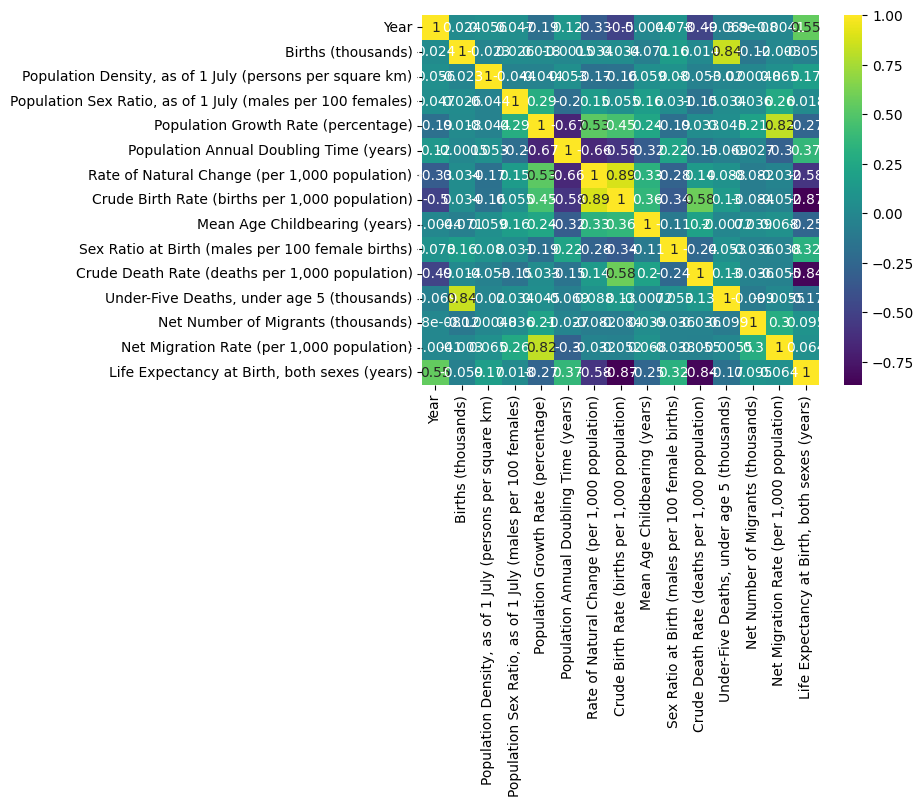

In [6]:
# بررسی تعداد مقادیر نال هر یک از ستون ها
display(df_estimates.isna().sum())
print("//////////////////////////////////////")

# بررسی dtype ستون ها
display(df_estimates.dtypes)
print("//////////////////////////////////////")

# بررسی کوریلیشن ستون ها
sns.heatmap(df_estimates.corr(), annot=True, cmap='viridis')

### داده های سال 2022

Region, subregion, country or area *                           0
Year                                                           0
Births (thousands)                                             1
Population Density, as of 1 July (persons per square km)       0
Population Sex Ratio, as of 1 July (males per 100 females)     1
Population Growth Rate (percentage)                            0
Population Annual Doubling Time (years)                       85
Rate of Natural Change (per 1,000 population)                  1
Crude Birth Rate (births per 1,000 population)                 1
Mean Age Childbearing (years)                                  1
Sex Ratio at Birth (males per 100 female births)               1
Crude Death Rate (deaths per 1,000 population)                 1
Under-Five Deaths, under age 5 (thousands)                     1
Net Number of Migrants (thousands)                             1
Net Migration Rate (per 1,000 population)                      1
Life Expectancy at Birth,

Region, subregion, country or area *                           object
Year                                                          float64
Births (thousands)                                            float64
Population Density, as of 1 July (persons per square km)      float64
Population Sex Ratio, as of 1 July (males per 100 females)    float64
Population Growth Rate (percentage)                           float64
Population Annual Doubling Time (years)                       float64
Rate of Natural Change (per 1,000 population)                 float64
Crude Birth Rate (births per 1,000 population)                float64
Mean Age Childbearing (years)                                 float64
Sex Ratio at Birth (males per 100 female births)              float64
Crude Death Rate (deaths per 1,000 population)                float64
Under-Five Deaths, under age 5 (thousands)                    float64
Net Number of Migrants (thousands)                            float64
Net Migration Rate (

//////////////////////////////////////


<Axes: >

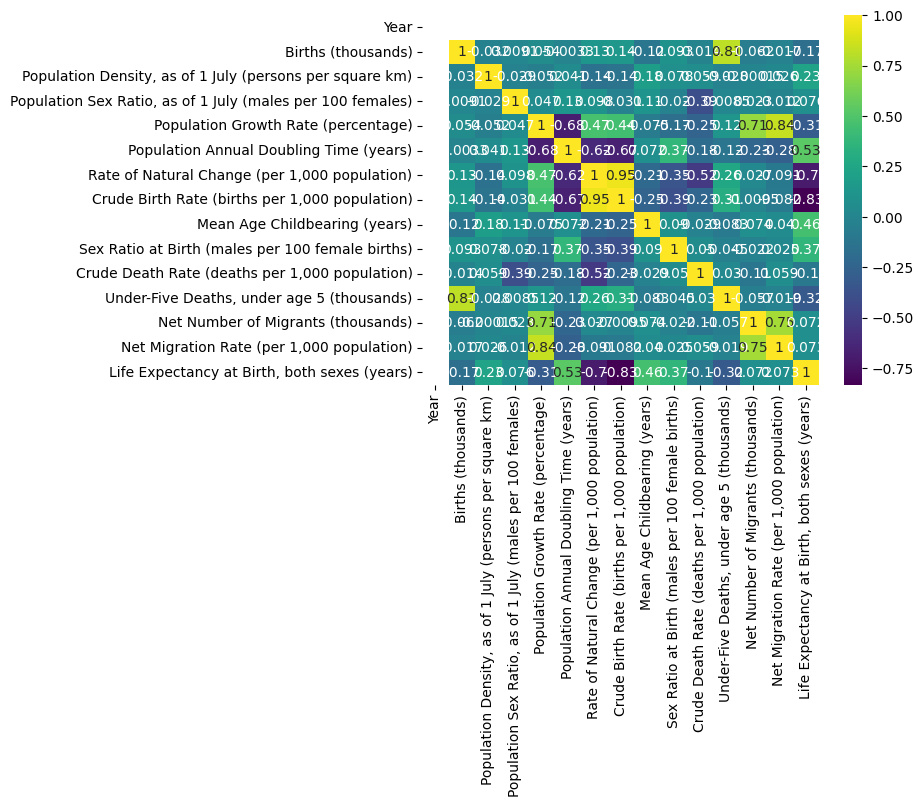

In [7]:
# بررسی تعداد مقادیر نال هر یک از ستون ها
print(df_medium.isna().sum())
print("//////////////////////////////////////")

# بررسی dtype ستون ها
display(df_medium.dtypes)
print("//////////////////////////////////////")

# بررسی کوریلیشن ستون ها
sns.heatmap(df_medium.corr(), annot=True, cmap='viridis')

## پیش پردازش

In [8]:
# حذف ستون: Population Annual Doubling Time (years)
df_estimates.drop(columns=["Population Annual Doubling Time (years)"], inplace=True)
df_medium.drop(columns=["Population Annual Doubling Time (years)"], inplace=True)

## مدل سازی با h20

In [9]:
target = "Life Expectancy at Birth, both sexes (years)"
train = df_estimates.copy()
train.dropna(subset=["Life Expectancy at Birth, both sexes (years)"], inplace=True)
test = df_medium.copy()
test.dropna(subset=["Life Expectancy at Birth, both sexes (years)"], inplace=True)

In [10]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.6+9-LTS-190, mixed mode, sharing)
  Starting server from D:\Projects\LifeExpectancy\venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\amira\AppData\Local\Temp\tmps7vva30o
  JVM stdout: C:\Users\amira\AppData\Local\Temp\tmps7vva30o\h2o_amira_started_from_python.out
  JVM stderr: C:\Users\amira\AppData\Local\Temp\tmps7vva30o\h2o_amira_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tehran
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_amira_ohfsvy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.975 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [11]:
h2o_train_data = h2o.H2OFrame(train)
h2o_test_data = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
X_columns = h2o_train_data.columns
X_columns.remove(target)

x_test_columns = h2o_test_data.columns
x_test_columns.remove(target)


In [13]:
model = H2ORandomForestEstimator(ntrees=100, max_depth=20, nfolds=5, seed=42)
model.train(x=X_columns, y=target, training_frame=h2o_train_data)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1676591696695_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         1.3944e+07             20           20           20            9297          9982          9662.27

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.40245478504352494
RMSE: 0.6343932416439546
MAE: 0.3535200186066555
RMSLE: 0.01583710796770295
Mean Residual Deviance: 0.40245478504352494

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.5085272227577878
RMSE: 0.7131109470186163
MAE: 0.37915957277833623
RMSLE: 0.018353039733965505
Mean Residual Deviance: 0.5085272227577878

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.379135   0.00636172  0.387036      0.370955      0.383214      0.379318      0.37515
mean_residual_deviance  0.509601   0.123808    0.571579      0.400475      0.417108      0.462674      0.696167
mse                     0.509601   0.123808    0.571579      0.400475      0.417108      0.462674      0.696167
r2                      0.996473   0.00090299  0.996081      0.997334      0.997127      0.996719      0.995102
residual_deviance       0.509601   0.123808    0.571579      0.400475      0.417108      0.462674      0.696167
rmse                    0.709853   0.0844765   0.756028      0.632831      0.645839      0.680201      0.834366
rmsle                   0.0177176  0.0055413   0.0220159     0.0120447     0.0115981     0.0196429     0.0232864

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_mae         training_deviance
---  -------------------  ----------------  -----------------  ------------------  -------------------  -------------------
     2023-02-17 03:26:25  1 min 22.818 sec  0.0                nan                 nan                  nan
     2023-02-17 03:26:26  1 min 23.148 sec  1.0                1.548862516615223   0.8206950137360126   2.3989750953756417
     2023-02-17 03:26:26  1 min 23.397 sec  2.0                1.5102265342496726  0.8028642998762114   2.280784184751777
     2023-02-17 03:26:26  1 min 23.628 sec  3.0                1.4261041618064487  0.7725689034106884   2.0337730803216734
     2023-02-17 03:26:27  1 min 23.883 sec  4.0                1.299454421918718   0.7271754594044536   1.6885817946441095
     2023-02-17 03:26:27  1 min 24.133 sec  5.0                1.2251169251953087  0.7012943649970776   1.5009114804000077
     2023-02-17 03:26:27  1 min 24.537 sec  6.0                1.1375835727674837  0.6701426572693606   1.294096385030433
     2023-02-17 03:26:27  1 min 24.824 sec  7.0                1.0890466634456928  0.6456766485837256   1.186022635162196
     2023-02-17 03:26:28  1 min 25.071 sec  8.0                1.0466146379939023  0.6195502750886499   1.0954022004631072
     2023-02-17 03:26:28  1 min 25.295 sec  9.0                0.9891900760082982  0.593099641962194    0.9784970064733028
---  ---                  ---               ---                ---                 ---                  ---
     2023-02-17 03:26:28  1 min 25.727 sec  11.0               0.9503801686141974  0.5701434135812161   0.9032224648951503
     2023-02-17 03:26:29  1 min 25.943 sec  12.0               0.9335494145953466  0.5621747056516184   0.8715145094913144
     2023-02-17 03:26:29  1 min 26.168 sec  13.0               0.9177669864716357  0.5495256098

In [14]:
# predict
pred_test = model.predict(h2o_test_data)
pred_train = model.predict(h2o_train_data)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [20]:
# compare with test data
pred_df_test = pred_test.as_data_frame()
pred_df_train = pred_train.as_data_frame()

# r^2 score train
print("r^2 score_train: ", r2_score(train[target], pred_df_train['predict']))
# r^2 score test
print("r^2 score_test: ", r2_score(test[target], pred_df_test['predict']))
print("//////////////////////////////////////")

# mean absolute error train
print("mean absolute error_train: ", mean_absolute_error(train[target], pred_df_train['predict']))
# mean absolute error test
print("mean absolute error_test: ", mean_absolute_error(test[target], pred_df_test['predict']))
print("//////////////////////////////////////")

# mean squared error train
print("mean squared error_train: ", mean_squared_error(train[target], pred_df_train['predict']))
# mean squared error test
print("mean squared error_test: ", mean_squared_error(test[target], pred_df_test['predict']))
print("//////////////////////////////////////")

# mean absolute percentage error train
print("mean absolute percentage error_train: ", mean_absolute_percentage_error(train[target], pred_df_train['predict']))
# mean absolute percentage error test
print("mean absolute percentage error_test: ", mean_absolute_percentage_error(test[target], pred_df_test['predict']))
print("//////////////////////////////////////")



r^2 score_train:  0.9995961100564457
r^2 score_test:  0.9864366485966456
//////////////////////////////////////
mean absolute error_train:  0.13387129742838794
mean absolute error_test:  0.6985753339428006
//////////////////////////////////////
mean squared error_train:  0.058530703266901844
mean squared error_test:  0.7990109574095328
//////////////////////////////////////
mean absolute percentage error_train:  0.0023479323906559053
mean absolute percentage error_test:  0.009485571892885859
//////////////////////////////////////


### رسم نمودار

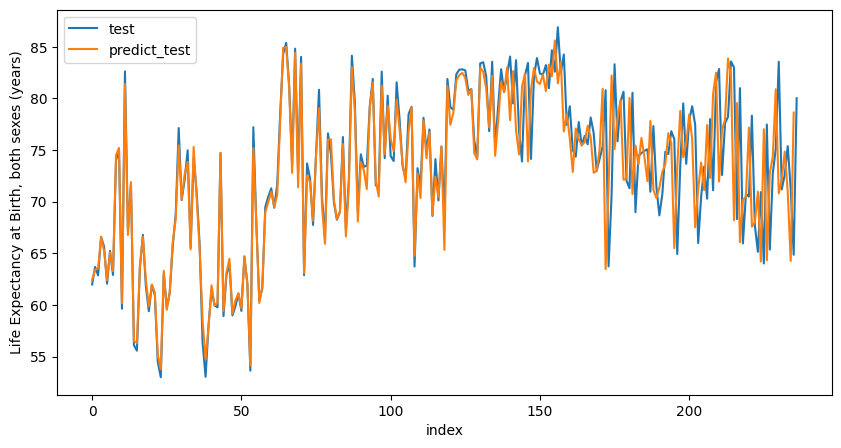

In [23]:
# plot
plt.figure(figsize=(10, 5))
plt.plot(test[target], label='test')
plt.plot(pred_df_test['predict'], label='predict_test')
plt.xlabel('index')
plt.ylabel(target)
plt.legend()